In [1]:
# 파일 불러오기 할 때 파일의 구조를 생각해 보는 것이 좋은

def read_documents(filename):
    
    with open(filename, encoding="utf-8") as f:
        documents = [line.split("\t") for line in f.read().splitlines()]
        documents = documents[1:]  # 첫번째 줄 제거
    
    
    return documents


train_docs = read_documents("ratings_train.txt")
test_docs = read_documents("ratings_test.txt")

In [2]:
print(len(train_docs))
print(len(test_docs))

150000
50000


### 함수 정의

In [3]:
# 첫번째 형태로 불러오기

import MeCab   # from konlpy.tag import Mecab
mecab = MeCab.Tagger()  # mecab = MeCab()

In [4]:
def mecab_morphs(text):
    morphs = []
    
    # 우리가 원하는 TOKEN\tPOS 의 형태를 추출하는 정규 표현식
    pattern = re.compile(".*\t[A-Z]+")
    
    # 패턴에 맞는 문자열을 추출하여 konlpy의 mecab 결과와 같아지도록 수정
    temp = [tuple(pattern.match(token).group(0).split("\t")) 
                   for token in mecab.parse(text).splitlines()[:-1]]
    
    # 추출한 토큰 중에 문자열만 선택
    for token in temp:
        morphs.append(token[0])  
    
    
    return morphs

In [5]:
def text_cleaning(docs):
        
    doc = re.sub("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "", doc)   
        
    return doc


def define_stopwords(path):
    
    SW = set()
    # 불용어를 추가하는 방법 1.
    # 특수 문자를 추가해보자. 파이썬의 특수문자 라이브러리를 이용해서 추가
#     for i in string.punctuation:
#         SW.add(i)
    
    # 불용어를 추가하는 방법 2.
    # stopwords-ko.txt에 직접 추가
    
    with open(path, encoding="utf-8") as f:
        for word in f:
            SW.add(word)

    return SW

def text_tokenizing(doc):
    return [word for word in mecab_morphs(doc) if word not in SW and len(word) > 1]

### 불러온 데이터를 품사 태그를 붙여서 토크나이징

In [12]:
import json
import os
import re
# from konlpy.tag import Okt
from pprint import pprint

# 두번째 형태소 분석기 불러오기
# okt = Okt()


# 불용어 작업
SW = define_stopwords("stopwords-ko.txt")


# 텍스트가 20만개이기 때문에, 정제하는 데 시간이 걸림
# 한 번 만들고 나서는 코드를 다시 실행시켰을 때, 또 정제할 필요없이 불러올 수 있도록 코드 작성

# train_docs.json : 형태소 분석기를 돌려서 나온 결과를 저장

# 학습용 데이터 셋 생성

if os.path.exists("train_docs.json"):
    # 불러오기
    with open("train_docs.json", encoding="utf-8") as f:            
        train_data = json.load(f)    
    
else:
    # 형태소 분석 line 에는 id document label 형태이므로 감상평이 필요함
    train_data = [(text_tokenizing(line[1]),line[2]) for line in train_docs if text_tokenizing(line[1])]
    
    with open("train_docs.json","w",encoding="utf-8") as f:
        json.dump(train_data, f, ensure_ascii=False, indent="\t") # indent 를 tab 기준으로 설정
        

# 테스트용 데이터 셋 생성
if os.path.exists("test_docs.json"):
    # 불러오기
    with open("test_docs.json", encoding="utf-8") as f:
        test_data = json.load(f)      
else:
    # 형태소 분석 line 에는 id document label 형태이므로 감상평이 필요함
    test_data = [(text_tokenizing(line[1]),line[2]) for line in test_docs if text_tokenizing(line[1])]
    
    with open("test_docs.json","w",encoding="utf-8") as f:
        json.dump(test_data, f, ensure_ascii=False, indent="\t") # indent 를 tab 기준으로 설정
        
        
pprint(train_data[0])
pprint(test_data[0])

[['진짜', '짜증', '네요', '목소리'], '0']
[['GDNTOPCLASSINTHECLUB'], '0']


### NLTK 를 이용한 histogram 분석
- 데이터 분석을 하기 위해 기본적인 정보 확인
- nltk 라이브러리를 이용한 전처리

In [8]:
import nltk  # tokenizer, histogram 그리기 위해 사용

total_tokens = [token for doc in train_data for token in doc[0]]
print(len(total_tokens))

1206841


In [15]:
text = nltk.Text(total_tokens, name = "NSMC")
print(len(set(text.tokens)))  # text를 조각내서 중복된 걸 제거 후 길이 알아보기
pprint(text.vocab().most_common(10)) 

51722
[('영화', 57614),
 ('..', 22813),
 ('는데', 11543),
 ('너무', 11002),
 ('정말', 9783),
 ('으로', 9322),
 ('네요', 9053),
 ('재밌', 9022),
 ('지만', 8366),
 ('진짜', 8326)]


### Histogram 그리기

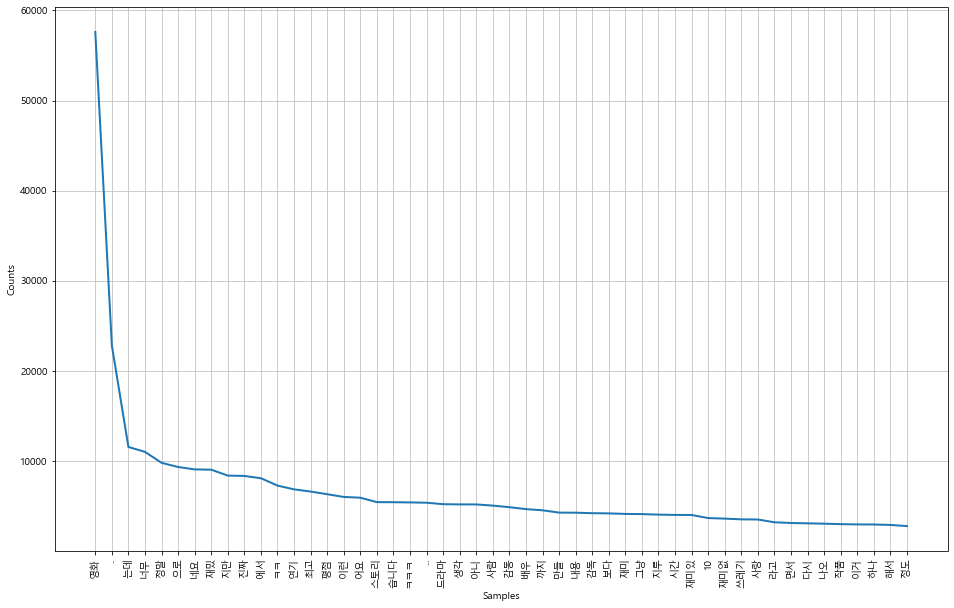

In [16]:
import matplotlib.pyplot as plt
import platform
from matplotlib import font_manager, rc

# %matplotlib inline

path = "c:/Windows/Fonts/malgun.ttf"

if platform.system() == "Darwin":
    rc('font', family = "AppleGothic")
elif platform.system() == "Windows":
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family = font_name)
else:
    print("unknown system...")
    
    
plt.figure(figsize=(16,10))
text.plot(50)

In [30]:
!pip install wordcloud

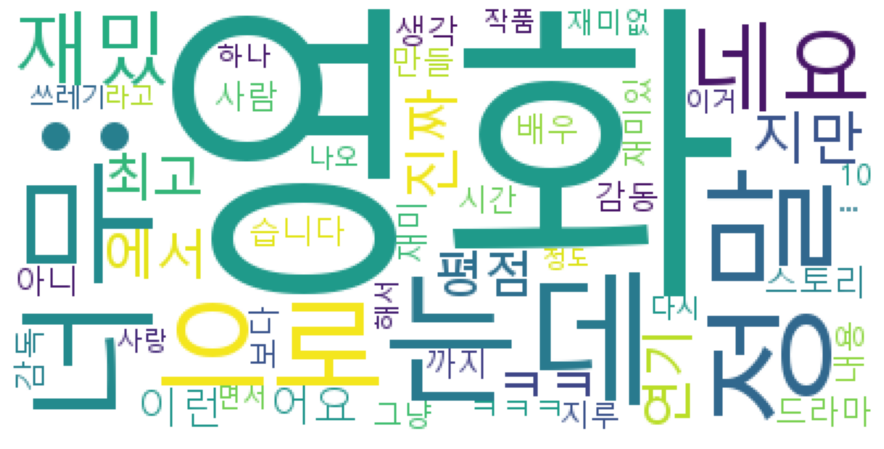

In [17]:
from wordcloud import WordCloud

data = text.vocab().most_common(50)

# font_path = '/Library/Fonts/AppleGothic.ttf'

# relative_scaling : wordclude 에서 가장 크게 보이는 건 빈도수가 높은 것인데 상대적으로 어느 비율로 줄 것인가?
wordcloud = WordCloud(font_path=path, relative_scaling=0.2, background_color='white').generate_from_frequencies(dict(data))

plt.figure(figsize=(16,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### 명사로 바꿔 워드 클라우드 그려보기

In [18]:
def mecab_nouns(text):
    nouns = []
    
    # 우리가 원하는 TOKEN\tPOS 의 형태를 추출하는 정규 표현식
    pattern = re.compile(".*\t[A-Z]+")
    
    
    temp = [tuple(pattern.match(token).group(0).split("\t")) 
                   for token in mecab.parse(text).splitlines()[:-1]]
    
    for token in temp:
        if token[1] == "NNG" or token[1]=="NNP" or token[1]=="NNB" or token[1]=="NNBC" or token[1]=="NP" or token[1]=="NR":
            nouns.append(token[0]) 
    return nouns


def text_tokenizing(doc):
    return [word for word in mecab_nouns(doc) if word not in SW and len(word) > 1]

In [19]:
import json
import os
import re

from pprint import pprint

SW = define_stopwords("stopwords-ko.txt")

if os.path.exists("train_docs_noun.json"):
    # 불러오기
    with open("train_docs_noun.json", encoding="utf-8") as f:            
        train_data_noun = json.load(f)    
    
else:
    # 형태소 분석 line 에는 id document label 형태이므로 감상평이 필요함
    train_data_noun = [(text_tokenizing(line[1]),line[2]) for line in train_docs if text_tokenizing(line[1])]
    
    with open("train_docs_noun.json","w",encoding="utf-8") as f:
        json.dump(train_data_noun, f, ensure_ascii=False, indent="\t") # indent 를 tab 기준으로 설정
        
        
if os.path.exists("test_docs_noun.json"):
    # 불러오기
    with open("test_docs_noun.json", encoding="utf-8") as f:
        test_data_noun = json.load(f)      
else:
    # 형태소 분석 line 에는 id document label 형태이므로 감상평이 필요함
    test_data_noun = [(text_tokenizing(line[1]),line[2]) for line in test_docs if text_tokenizing(line[1])]
    
    with open("test_docs_noun.json","w",encoding="utf-8") as f:
        json.dump(test_data_noun, f, ensure_ascii=False, indent="\t") # indent 를 tab 기준으로 설정
        
        
pprint(train_data_noun[0])
pprint(test_data_noun[0])

[['진짜', '짜증', '네요', '목소리'], '0']
[['GDNTOPCLASSINTHECLUB'], '0']


In [20]:
import nltk  # tokenizer, histogram 그리기 위해 사용

total_tokens = [token for doc in train_data_noun for token in doc[0]]
print(len(total_tokens))

text = nltk.Text(total_tokens, name = "NSMC")
print(len(set(text.tokens)))  # text를 조각내서 중복된 걸 제거 후 길이 알아보기
pprint(text.vocab().most_common(10)) 

1206841
51722
[('영화', 57614),
 ('..', 22813),
 ('는데', 11543),
 ('너무', 11002),
 ('정말', 9783),
 ('으로', 9322),
 ('네요', 9053),
 ('재밌', 9022),
 ('지만', 8366),
 ('진짜', 8326)]


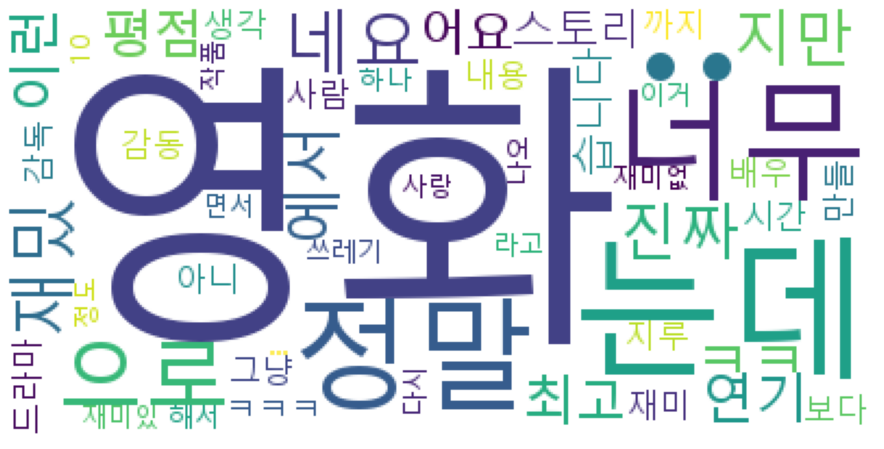

In [16]:
data = text.vocab().most_common(50)

# font_path = '/Library/Fonts/AppleGothic.ttf'

# relative_scaling : wordclude 에서 가장 크게 보이는 건 빈도수가 높은 것인데 상대적으로 어느 비율로 줄 것인가?
wordcloud = WordCloud(font_path=path, relative_scaling=0.2, background_color='white').generate_from_frequencies(dict(data))

plt.figure(figsize=(16,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()